## Conduct Preliminary Linear Analysis of Upper Yaquina River QUAL2Kw Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyemu
import re
import subprocess

## Working Directory

Check working directory. 
Working directory needs to have all the files used in the PEST run

In [2]:
os.getcwd()

'C:\\Temp\\kevin_scratch\\Jupyter_Notebooks'

Moving one level up

In [3]:
os.chdir('..')

Check again

In [4]:
os.getcwd()

'C:\\Temp\\kevin_scratch'

## Select observations used for forecasts

We can do error analaysis on model output using linear analysis. We need to select which observations to use as forecasts. For this example, we will use the minimum do for each reach. We will load the PEST control file and minipulate the observations using pandas data frame methods to get the observation names of the minimun do values in the PEST control file.

In [12]:
# Run PEST
proc = subprocess.Popen(['pest', 'control.pst'],stdout=subprocess.PIPE)
while proc.poll() is None:
    line = proc.stdout.readline()
    print line.rstrip()
print "Run Stop/Complete"


PEST Version 14.2. Watermark Numerical Computing.

PEST is running in parameter estimation mode.

PEST run record: case control
(See file control.rec for full details.)

Model command line:
model.bat

Running model .....

   Running model 1 time....
   Sum of squared weighted residuals (ie phi)               =   1600.0
   Contribution to phi from observation group "flow"        =   100.00
   Contribution to phi from observation group "fcob"        =   100.00
   Contribution to phi from observation group "orgn"        =   100.00
   Contribution to phi from observation group "nh4"         =   100.00
   Contribution to phi from observation group "no3"         =   100.00
   Contribution to phi from observation group "orgp"        =   100.00
   Contribution to phi from observation group "inorgp"      =   100.00
   Contribution to phi from observation group "doave"       =   100.00
   Contribution to phi from observation group "domin"       =   100.00
   Contribution to phi from observation

In [5]:
p = pyemu.Pst('control.pst') # load the PEST control file

In [6]:
do_fore = p.observation_data[p.observation_data['obgnme'] == 'domin'] # get the minimum do observations

In [7]:
# add a column with reach number
do_fore = do_fore.assign(rch=[re.sub(".{2}$","", re.sub("[^0-9]", "", x)) for x in do_fore['obsnme']])

In [8]:
# get the minmum values for each reach and put observation names in a list
do_mins = do_fore.sort_values('obsval').groupby('rch', as_index=False).first()
l_forecasts = do_mins['obsnme'].tolist()

In [9]:
# here is the list
print l_forecasts

['domin0502', 'domin0606', 'domin0808']


In [10]:
# update the group name and weight for the forecasts in the observation data
p.observation_data.at[p.observation_data.index.isin(l_forecasts), 'obgnme'] = 'forecast'
p.observation_data.at[p.observation_data.index.isin(l_forecasts), 'weight'] = 0
p.observation_data[p.observation_data.index.isin(l_forecasts)]

,obsnme,obsval,weight,obgnme
obsnme,,,,
domin0502,domin0502,7.89,0.0,forecast
domin0606,domin0606,7.18,0.0,forecast
domin0808,domin0808,7.93,0.0,forecast


In [19]:
# increase the observation groups by 1 to include the forecast group
p.control_data.nobsgp  = 17

In [20]:
# add the forecast group to the observation groups list
p.obs_groups.append('forecast')
p.obs_groups

['domin',
 'phave',
 'doave',
 'tempave',
 'flow',
 'forecast',
 'orgn',
 'tempmin',
 'fcob',
 'inorgp',
 'phmax',
 'phmin',
 'domax',
 'no3',
 'orgp',
 'nh4',
 'tempmax']

In [21]:
p.write('control_sc.pst')

In [5]:
!pestchek control_sc.pst


PESTCHEK Version 14.2. Watermark Numerical Computing.

Errors ----->
No errors encountered.

Warnings ----->
NOPTMAX provided as -1. No optimisation will be carried out; objective 
  function, residuals and statistics will be recorded for initial parameter 
  estimates only.


In [17]:
os.getcwd()

'C:\\Temp\\kevin_scratch'

In [15]:
proc = subprocess.Popen(['pest', 'control_sc.pst'],stdout=subprocess.PIPE)
while proc.poll() is None:
    line = proc.stdout.readline()
    print line.rstrip()
print "Run Stop/Complete"


PEST Version 14.2. Watermark Numerical Computing.

PEST is running in parameter estimation mode.

PEST run record: case control_sc
(See file control_sc.rec for full details.)

Model command line:
model.bat

Running model .....

   Running model 1 time....
   Sum of squared weighted residuals (ie phi)               =   1600.0
   Contribution to phi from observation group "domin"       =   100.00
   Contribution to phi from observation group "phave"       =   100.00
   Contribution to phi from observation group "doave"       =   100.00
   Contribution to phi from observation group "tempave"     =   100.00
   Contribution to phi from observation group "flow"        =   100.00
   Contribution to phi from observation group "forecast"    =   0.0000
   Contribution to phi from observation group "orgn"        =   100.00
   Contribution to phi from observation group "tempmin"     =   100.00
   Contribution to phi from observation group "fcob"        =   100.00
   Contribution to phi from obser

# General parameter uncertainty analysis--evaluating posterior parameter covariance

Let's calculate and save the posterior parameter covariance matrix. In this linear analysis, the posterior covariance represents the updated covariance following notional calibration as represented by the Jacobian matrix and both prior parameter and epistemic observation covariance matrices using the Schur complement:

In [11]:
# load the Jacobian
sc = pyemu.sc.Schur(jco="control_sc.jco")

In [12]:
#writes posterior covariance to a text file
sc.posterior_parameter.to_ascii("control_sc_post.cov", icode = 1)

In [13]:
#easy to read in the notebook
sc.posterior_parameter.to_dataframe().sort_index().\
sort_index(axis=1).iloc[0:10,0:10] 

,algae1,algae2,algae3,algae4,algae5,algae6,algae7,algae8,bpbios,bpcc
algae1,1.286577,-0.451848,-0.036317,0.008055,0.018491,0.024105,0.041177,0.010286,0.424995,-0.006232
algae2,-0.451848,1.111620,-0.387300,-0.080328,0.015058,-0.016969,0.004702,0.003290,-0.563135,-0.004796
algae3,-0.036317,-0.387300,0.479448,0.066931,-0.014461,-0.000704,-0.001411,-0.002183,-0.152430,0.000751
algae4,0.008055,-0.080328,0.066931,0.083872,-0.019704,0.000779,-0.001561,0.000381,-0.064624,-0.001983
algae5,0.018491,0.015058,-0.014461,-0.019704,0.017169,0.006626,0.005731,0.002993,0.008888,-0.002774
algae6,0.024105,-0.016969,-0.000704,0.000779,0.006626,0.021534,0.005507,0.003391,-0.007009,0.002900
algae7,0.041177,0.004702,-0.001411,-0.001561,0.005731,0.005507,0.025868,0.000430,0.006131,-0.001101
algae8,0.010286,0.003290,-0.002183,0.000381,0.002993,0.003391,0.000430,0.002797,-0.001971,-0.002038
bpbios,0.424995,-0.563135,-0.152430,-0.064624,0.008888,-0.007009,0.006131,-0.001971,1.000721,-0.006318
bpcc,-0.006232,-0.004796,0.000751,-0.001983,-0.002774,0.002900,-0.001101,-0.002038,-0.006318,0.012462


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 761 parameters. The .get_parameters_summary() method is the easy way:

,percent_reduction,post_var,prior_var
bpphoswc,99.996692,0.000052,1.56250
bpexc,99.963812,0.000499,1.38002
algae8,99.908679,0.002797,3.06250
bpdr,99.719584,0.003870,1.38002
algae5,99.439394,0.017169,3.06250
bpnitrwc,99.412293,0.009183,1.56250
sod6,99.345458,0.020045,3.06250
algae6,99.296855,0.021534,3.06250
sod8,99.187996,0.024868,3.06250
algae7,99.155343,0.025868,3.06250


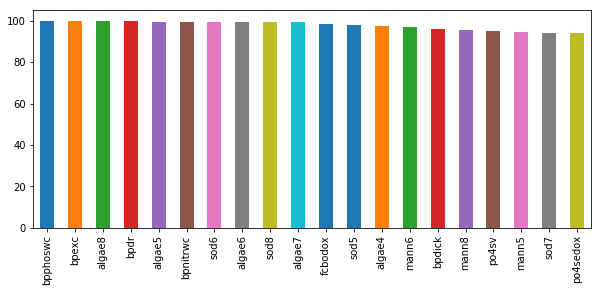

In [14]:
#get the parameter uncertainty dataframe and sort it
par_sum = sc.get_parameter_summary().\
   sort_values("percent_reduction",ascending=False)
#make a bar plot of the percent reduction 
par_sum.loc[par_sum.index[:20],"percent_reduction"].\
   plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 entries
par_sum.iloc[0:10,:]

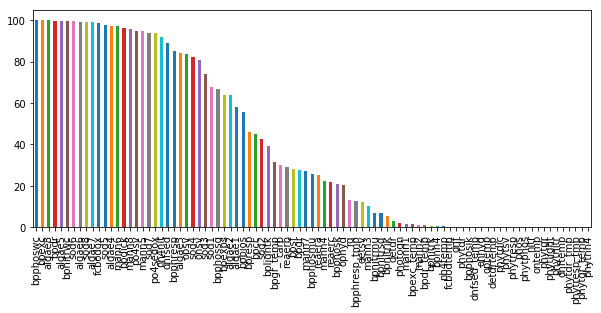

In [15]:
#plot more of the percent reduction 
par_sum.loc[par_sum.index[:89],"percent_reduction"].\
   plot(kind="bar",figsize=(10,4),edgecolor="none")

Now lets look at the other end of the parameter uncertainty summary -- the values with the least amount of uncertainty reduction. Note that calling get_parameter_summary() again results in no additional computation but is just accessing information already calculated

,percent_reduction,post_var,prior_var
phytnh4,2.386902e-07,0.005664,0.005664
phytgr_temp,4.252292e-07,0.000054,0.000054
phytresp_tmp,7.129558e-07,0.000054,0.000054
phytdr_tmp,1.020015e-06,0.000054,0.000054
dnftemp,1.877630e-06,0.000054,0.000054
phytnitr,1.134886e-05,0.009897,0.009897
phytlight,2.322536e-05,0.012063,0.012063
phytgr,1.078738e-04,0.005664,0.005664
ontemp,1.283213e-04,0.000054,0.000054
nitr,1.776520e-04,0.004073,0.004073


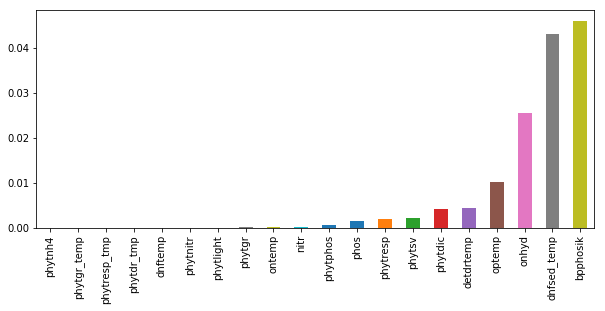

In [16]:
# sort in increasing order without 'ascending=False'
par_sum = sc.get_parameter_summary().sort_values("percent_reduction") 
# plot the first 20
par_sum.loc[par_sum.index[:20],"percent_reduction"].\
   plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 
par_sum.iloc[0:20,:]

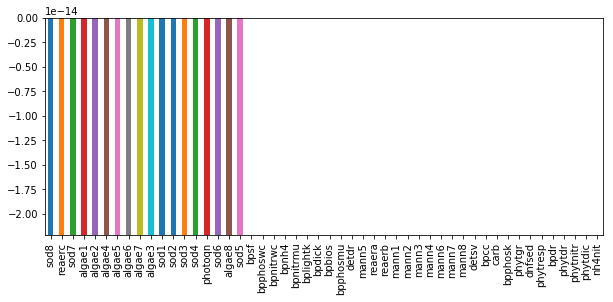

In [30]:
# plot the first 50
par_sum.loc[par_sum.index[:50],"percent_reduction"].\
   plot(kind="bar",figsize=(10,4),edgecolor="none")

## Compare to sensitvity from QUAL2Kw auto-calibration results

In [44]:
sc.pst.parameter_data.groupby("pargp").groups

{'algae': Index([u'algae1', u'algae2', u'algae3', u'algae4', u'algae5', u'algae6',
        u'algae7', u'algae8'],
       dtype='object', name=u'parnme'),
 'basl': Index([u'bpgr', u'bpgr_temp', u'bpresp', u'bpphresp', u'bpphresp_tmp',
        u'bpexc', u'bpexc_temp', u'bpdr', u'bpcc', u'bpdr_temp', u'bpnitrk',
        u'bpphosk', u'bpdick', u'bplightk', u'bpnh4', u'bpnitrsq', u'bpphossq',
        u'bpnitrmu', u'bpphosmu', u'bpnitrik', u'bpphosik', u'bpnitrwc',
        u'bpphoswc', u'bpsf', u'bpexps', u'bpbios'],
       dtype='object', name=u'parnme'),
 'cnp': Index([u'carb', u'nitr', u'phos'], dtype='object', name=u'parnme'),
 'detr': Index([u'detdr', u'detdrtemp', u'detsv'], dtype='object', name=u'parnme'),
 'fcbod': Index([u'fcbodox', u'fcbodtemp'], dtype='object', name=u'parnme'),
 'mann': Index([u'mann1', u'mann2', u'mann3', u'mann4', u'mann5', u'mann6', u'mann7',
        u'mann8'],
       dtype='object', name=u'parnme'),
 'nh4n': Index([u'nh4nit', u'nh4temp'], dtype='object', name=

# Forecast uncertainty

Now let's examine the prior and posterior variance of the forecasts. The uncertainty in parameters directly impacts the uncertainty of forecasts made with the model. Four forecasts were identified for analysis, as described above:

sw_gw_0: the surface water/groundwater exchange during the calibration stress period
sw_gw_1: the surface water/groundwater exchange during the prediction stress period
or28c05_0: the head in well cell 6 (row 28, column 5) at the end of the calibration stress period
or28c05_1: the head in well cell 6 (row 28, column 5) at the end of the prediction stress period

,percent_reduction,post_var,prior_var
domin0606,99.982677,0.127377,735.307624
domin0808,99.979114,25.964724,124316.304304
domin0502,99.843626,0.147558,94.362529


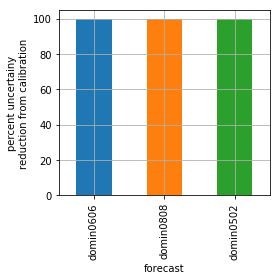

In [26]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax = sc.get_forecast_summary().percent_reduction.plot(kind='bar',
                                                      ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()
plt.savefig("forecast_sum.pdf")
sc.get_forecast_summary()

# Parameter contribution to forecast uncertainty

## Overview

As we observed above, information cascades from observations to parameters and then out to forecasts. With specific forecasts of interest, we can evaluate which information contributes most to forecast uncertainty. This is accomplished by assuming a parameter (or group of parameters) is perfectly known and assessing the forecast uncertainty under that assumption. Of course, this is a pretty serious approximation because perfect knowledge of a parameter can never be obtained in reality. In fact, it is difficult to calculate what, for example, a pumping test will provide in terms of uncertainty reduction for a parameter. Nonetheless, this metric can still provide important insights into model dynamics and help guide future data collection efforts.

Evaluating parameters by groups
With the Freyberg example, we can evaluate parameter contributions to forecast uncertainty with groups of parameters by type.

In [17]:
df = sc.get_par_group_contribution()
df

,domin0502,domin0606,domin0808
base,0.140299,0.121497,25.517322
phyt,0.140299,0.121497,25.517321
orgn,0.140154,0.121319,25.490491
sod,0.122107,0.108336,24.472449
cnp,0.140275,0.121231,25.448046
basl,0.127688,0.090024,14.269354
no3n,0.125601,0.117503,25.471131
po4p,0.139561,0.120054,25.180170
reaer,0.140099,0.117331,25.111770
phsyn,0.140218,0.121421,25.364329


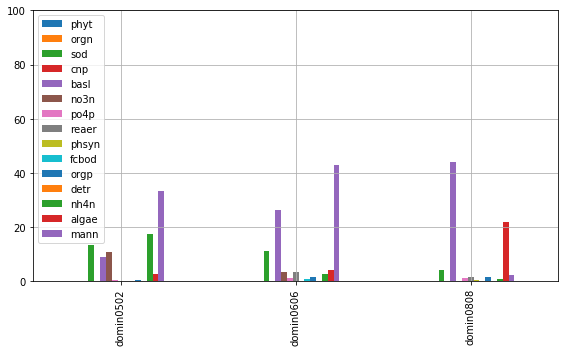

In [28]:
#calc the percent reduction in posterior
df_percent = 100.0 * (df.loc["base",:]-df)/\
                      df.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
ax = df_percent.T.plot(kind="bar", ylim=[0,100],figsize=(8,5))
ax.grid()
plt.tight_layout()
plt.savefig('indiv_pars_certain_future.pdf')

In [33]:
pargp = sc.pst.parameter_data.groupby("pargp").groups
pargp.items()

[('algae',
  Index([u'algae1', u'algae2', u'algae3', u'algae4', u'algae5', u'algae6',
         u'algae7', u'algae8'],
        dtype='object', name=u'parnme')),
 ('phyt',
  Index([u'phytgr', u'phytgr_temp', u'phytresp', u'phytresp_tmp', u'phytdr',
         u'phytdr_tmp', u'phytnitr', u'phytphos', u'phytdic', u'phytlight',
         u'phytnh4', u'phytsv'],
        dtype='object', name=u'parnme')),
 ('orgn',
  Index([u'onhyd', u'ontemp', u'onsv'], dtype='object', name=u'parnme')),
 ('sod',
  Index([u'sod1', u'sod2', u'sod3', u'sod4', u'sod5', u'sod6', u'sod7', u'sod8'], dtype='object', name=u'parnme')),
 ('cnp', Index([u'carb', u'nitr', u'phos'], dtype='object', name=u'parnme')),
 ('po4p', Index([u'po4sv', u'po4sedox'], dtype='object', name=u'parnme')),
 ('reaer',
  Index([u'reaera', u'reaerb', u'reaerc'], dtype='object', name=u'parnme')),
 ('mann',
  Index([u'mann1', u'mann2', u'mann3', u'mann4', u'mann5', u'mann6', u'mann7',
         u'mann8'],
        dtype='object', name=u'parnme')),
 

In [36]:
for gp,panmes in pargp.items():
    ax = pyemu.helpers.plot_summary_distributions(par_sum.loc[pargp[gp],:],label_post=True)
    ax.set_title(gp)
    plt.savefig(gp+".pdf")

TypeError: unhashable type: 'Index'

In [34]:
grp = pg[6]
pl = p_sc.parameter_data.parnme[p_sc.parameter_data.pargp == grp]
pl_sum = par_sum[par_sum.index.isin(pl)]
pl_sum.post_stdev[2]


NameError: name 'pg' is not defined

In [23]:
fore_sum = sc.get_forecast_summary()
fore_sum

,percent_reduction,post_var,prior_var
domin0606,99.983477,0.121497,735.307624
domin0808,99.979474,25.517322,124316.304304
domin0502,99.851319,0.140299,94.362529
